# Predicting Car Prices with Linear and Non-linear Models

## Table of Contents

- [1. Introduction](#1.-Introduction)
- [2. Exploring and Cleaning the Data](#2.-Exploring-and-Cleaning-the-Data)
- [3. Checking Linear Regression Assumptions](#3.-Checking-Linear-Regression-Assumptions)
    - [3.1. Linearity](#3.1.-Linearity)
    - [3.2. No Multicollinearity](#3.2.-No-Multicollinearity)
    - [3.3. Normality and Homoscedasticity](#3.3.-Normality-and-Homoscedasticity)
    - [3.4. No Autocorrelation](#3.4.-No-Autocorrelation)
- [4. Evaluating the OLS Linear Model](#4.-Evaluating-the-OLS-Linear-Model)
- [5. Building Polynomial and Spline Models](#5.-Building-Polynomial-and-Spline-Models)
- [6. Conclusion](#6.-Conclusion)

## 1. Introduction

In this project, we'll aim to build predictive models for car prices, using both linear and non-linear approaches. We will start by exploring and cleaning the dataset to ensure it’s suitable for modeling. The dataset includes the following columns:

- `Brand` – Car manufacturer.
- `Price` – The price of the car.
- `Body` – Car body type (e.g. `sedan`, `crossover`).
- `Mileage` – Car mileage in kilometers.
- `EngineV` – Engine volume in liters.
- `Engine Type` – Type of engine (e.g. `petrol`, `diesel`).
- `Registration` – Indicates whether the car is registered.
- `Year` – Year of manufacture.
- `Model` – Car model.

Next, we will check key linear regression assumptions such as linearity, multicollinearity, normality, and homoscedasticity. Once these assumptions are assessed, we will evaluate the OLS linear model. Finally, we will build polynomial and spline models to capture non-linear patterns and compare their performance to identify the best approach.

To begin, let's import the necessary libraries and take a quick look at our dataset.

In [1]:
# Import libraries for data manipulation, visualization, and machine learning
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import f_regression, RFE
from sklearn.metrics import r2_score

from sklearn.preprocessing import PolynomialFeatures, SplineTransformer, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# Load the used cars dataset and display the first five rows
cars = pd.read_csv('Datasets/used_cars_listings.csv')
cars.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277000,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427000,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358000,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240000,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120000,2.0,Petrol,yes,2011,Rav 4


The first five rows show secondhand car prices from various brands and different years, including `BMW`, `Audi`, and `Mercedes-Benz`. Prices vary significantly depending on the car's specifications. The cars differ in engine type, engine volume, and body style, reflecting a diverse selection. Mileage also varies widely, suggesting different levels of usage, with all five vehicles being registered. 

## 2. Exploring and Cleaning the Data

After loading the used cars dataset, we will explore it further by checking for duplicate rows, missing data, and outliers, and by generating summary statistics for all columns. Also, we'll drop features that we consider irrelevant or less useful for our predictions.

In [2]:
# Check and remove duplicate rows from the dataset
print(f"Number of duplicate rows before: {cars.duplicated().sum()}")
cars.drop_duplicates(inplace=True)
print(f"Number of duplicate rows after: {cars.duplicated().sum()}")

Number of duplicate rows before: 73
Number of duplicate rows after: 0



Before removing duplicates, there were `73` duplicate rows in the dataset. After cleaning, all duplicates were removed, leaving `0` duplicates.

In [3]:
# Generate summary statistics for all columns, including categorical features
cars.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4272,4123.000000,4272,4272.000000,4122.000000,4272,4272,4272.000000,4272
unique,7,NaN,6,NaN,NaN,4,2,NaN,312
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,927,NaN,1629,NaN,NaN,1969,3874,NaN,192
mean,NaN,18939.537220,NaN,163207.631086,2.786742,NaN,NaN,2006.419944,NaN
std,NaN,24762.368347,NaN,105160.123451,5.108975,NaN,NaN,6.694256,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6900.000000,NaN,90000.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11300.000000,NaN,157000.000000,2.200000,NaN,NaN,2008.000000,NaN
75%,NaN,21000.000000,NaN,230000.000000,3.000000,NaN,NaN,2012.000000,NaN


The dataset includes `4,272` observations with cars from `7` brands, where `Volkswagen` appears most frequently. Prices range widely from `600` to `300,000 USD`, with a mean of around `19,419 USD`. The most common body type is `sedan`, and the average mileage is `163,207 km`, though it varies significantly. Engine volumes are between `1.8` and `3.0` liters `50%` of the time, with some extreme outliers. `Diesel` is the most common engine type, and most cars are registered. Also, the years range from `1969` to `2016`, with the median year being `2008`.

The `Model` column, with `312` unique values, should be removed because it could introduce high dimensionality and sparsity into the dataset when converted to dummy variables. This can lead to overfitting, increased computation time, and decreased model performance.

In [4]:
# Drop the 'Model' column to avoid high dimensionality in the model
cars.drop(['Model'], axis=1, inplace=True)

A key step in data exploration is displaying the distribution of a variable. This makes it easy to spot anomalies such as outliers and helps decide whether a feature should be transformed. So, let's create a 4×4 plot displaying histograms for each numerical column in the used cars dataset.

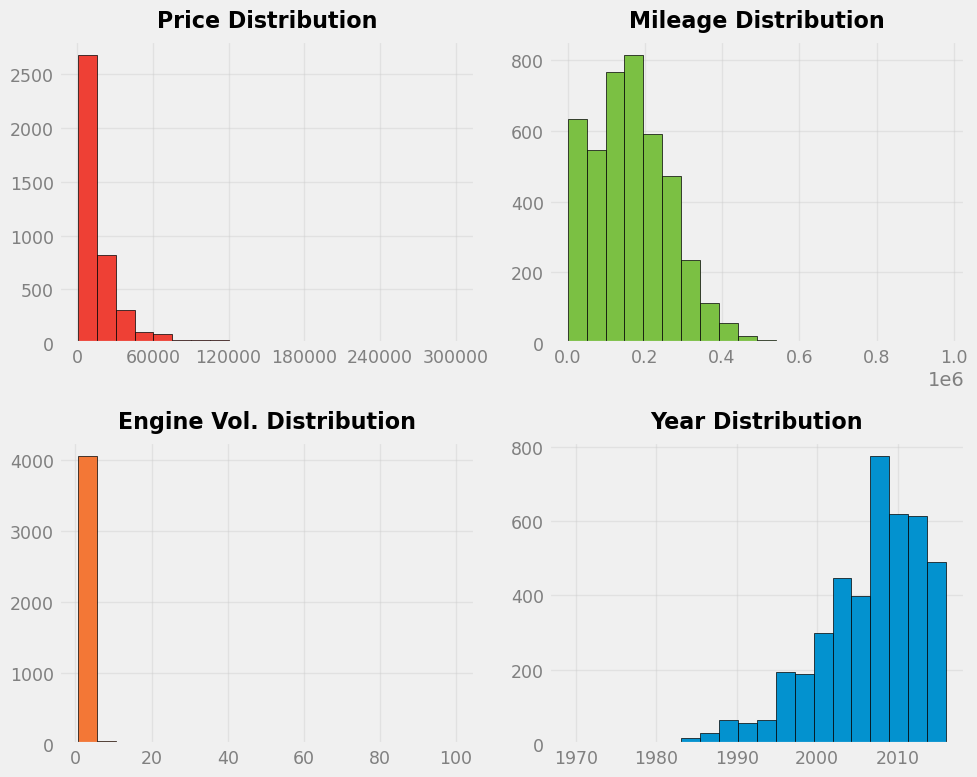

In [5]:
# Apply fivethirtyeight style and create subplots
plt.style.use('fivethirtyeight')
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot histograms for 'Price', 'Mileage', 'EngineV', and 'Year'
cars['Price'].plot(kind='hist', ax=axes[0, 0], color='#ee4035', bins=20, edgecolor='black')
axes[0, 0].set_title('Price Distribution', weight='bold', size=16, pad=10)
axes[0, 0].set_xticks(np.arange(0, 360000, 60000))
axes[0, 0].set_ylabel('')

cars['Mileage'].plot(kind='hist', ax=axes[0, 1], color='#7bc043', bins=20, edgecolor='black')
axes[0, 1].set_title('Mileage Distribution', weight='bold', size=16, pad=10)
axes[0, 1].set_ylabel('')

cars['EngineV'].plot(kind='hist', ax=axes[1, 0], color='#f37736', bins=20, edgecolor='black')
axes[1, 0].set_title('Engine Vol. Distribution', weight='bold', size=16, pad=10)
axes[1, 0].set_ylabel('')

cars['Year'].plot(kind='hist', ax=axes[1, 1], color='#0392cf', bins=20, edgecolor='black')
axes[1, 1].set_title('Year Distribution', weight='bold', size=16, pad=10)
axes[1, 1].set_ylabel('')

# Customize tick labels and gridlines
for ax in axes.flatten():
    ax.tick_params(axis='both', colors='grey', labelsize=12.5)
    ax.grid(alpha=0.4)

# Adjust layout and display plot
plt.tight_layout()
plt.show()

Clearly, outliers are present in each of the four numerical features. Since outliers can significantly impact OLS linear regression, we decided to address this issue by removing the problematic samples.

The distributions for price, engine volume, and mileage are highly right-skewed, meaning that outliers are found among higher prices, larger engine volumes, and greater mileages, respectively. Conversely, the year distribution is left-skewed, with outliers appearing among earlier years in the data.

To gain a more detailed perspective, let’s examine the `10` highest values for `Price`, `EngineV`, and `Mileage`, as well as the `10` earliest values in `Year`.

In [6]:
# Display the top 10 highest values for 'Price', 'EngineV', 'Mileage', and the 10 earliest years
display(cars['Price'].value_counts().sort_index().tail(10))
display(cars['EngineV'].value_counts().sort_index().tail(10))
display(cars['Mileage'].value_counts().sort_index().tail(10))
display(cars['Year'].value_counts().sort_index().head(10))

Price
189999.0    1
195000.0    2
199999.0    1
200000.0    1
219900.0    2
222000.0    1
249999.0    1
250000.0    1
295000.0    2
300000.0    2
Name: count, dtype: int64

EngineV
20.00    2
22.00    1
28.00    1
30.00    1
55.00    1
66.00    1
74.00    1
75.00    1
90.00    1
99.99    8
Name: count, dtype: int64

Mileage
550000    1
575000    1
580000    1
630000    2
650000    2
800000    1
810000    1
850000    1
940000    1
980000    1
Name: count, dtype: int64

Year
1969     1
1978     2
1979     3
1980     3
1982     1
1983     2
1984     3
1985    13
1986    12
1987    19
Name: count, dtype: int64

The outliers for price include extremely high values up to `$300,000`. For engine volume, outliers are marked by unusually large values up to `99.99` liters. Additionally, mileage outliers feature very high readings, reaching up to `980,000 Km`. Lastly, year outliers are concentrated in the earlier years, from `1969` to around the `1980s`.

Typically, the maximum car engine volume is generally around `5.0` to `6.0` liters for high-performance or luxury vehicles. Some other vehicles may have engine volumes that exceed this range.

Therefore, we'll remove extreme outliers by keeping only the lowest `99%` of prices and mileages, values above the lowest `1%` of years, and cars with engine volumes up to `6.5` liters.

In [7]:
# Remove outliers by keeping only the lowest 99% of prices
threshold_value = cars['Price'].quantile(0.99)
cars = cars[cars['Price'] < threshold_value]

# Remove outliers by keeping only the lowest 99% of mileages
threshold_value = cars['Mileage'].quantile(0.99)
cars = cars[cars['Mileage'] < threshold_value]

# Remove outliers by keeping only values above the lowest 1% of years
threshold_value = cars['Year'].quantile(0.01)
cars = cars[cars['Year'] > threshold_value]

# Remove outliers by keeping only cars with engine volume up to 6.5 liters
cars = cars[cars['EngineV'] <= 6.5]

# Print total missing values and the shape of the dataset
print(f"Number of missing values in the dataset: {cars.isnull().sum().sum()}")
print(f"Number of rows and columns in the dataset: {cars.shape}")

Number of missing values in the dataset: 0
Number of rows and columns in the dataset: (3818, 8)


After removing extreme outliers, the number of missing values in the data has surprisingly dropped to `0`, indicating that only the outlier rows contained missing data. Additionally, the number of rows decreased from `4,272` to `3,818`, resulting in a reduction of `454` observations.

Next, let's recreate the 4×4 plot displaying histograms for each of the four numerical columns to observe the difference.

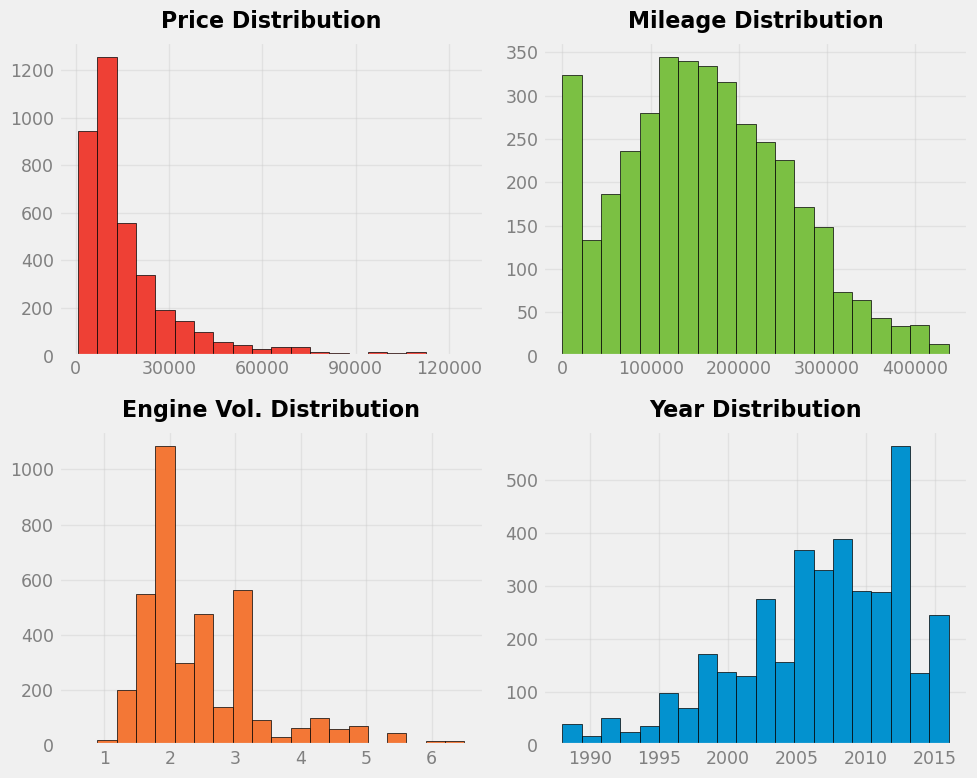

In [8]:
# Recreate the subplots to observe the difference
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot histograms for 'Price', 'Mileage', 'EngineV', and 'Year'
cars['Price'].plot(kind='hist', ax=axes[0, 0], color='#ee4035', bins=20, edgecolor='black')
axes[0, 0].set_title('Price Distribution', weight='bold', size=16, pad=10)
axes[0, 0].set_xticks(np.arange(0, 150000, 30000))
axes[0, 0].set_ylabel('')

cars['Mileage'].plot(kind='hist', ax=axes[0, 1], color='#7bc043', bins=20, edgecolor='black')
axes[0, 1].set_title('Mileage Distribution', weight='bold', size=16, pad=10)
axes[0, 1].set_ylabel('')

cars['EngineV'].plot(kind='hist', ax=axes[1, 0], color='#f37736', bins=20, edgecolor='black')
axes[1, 0].set_title('Engine Vol. Distribution', weight='bold', size=16, pad=10)
axes[1, 0].set_ylabel('')

cars['Year'].plot(kind='hist', ax=axes[1, 1], color='#0392cf', bins=20, edgecolor='black')
axes[1, 1].set_title('Year Distribution', weight='bold', size=16, pad=10)
axes[1, 1].set_ylabel('')

# Customize tick labels and gridlines
for ax in axes.flatten():
    ax.tick_params(axis='both', colors='grey', labelsize=12.5)
    ax.grid(alpha=0.4)

# Adjust layout and display plot
plt.tight_layout()
plt.show()

As we can see, the distributions for `Price`, `EngineV`, `Mileage`, and `Year` have become less skewed, meaning that we successfully removed extreme outliers.

Before concluding our data cleaning, note that two entries have unusually small engine volumes (`0.65` and `0.60` liters), which is uncommon for `BMW` or `Mercedes-Benz`. Given these may be data errors or refer to specialized models, it's best to remove these two points for accuracy.

In [9]:
# Display and remove cars with engine volume less than 1 liter
display(cars[cars['EngineV'] < 1])
cars = cars[cars['EngineV'] >= 1]

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
188,BMW,38888.0,vagon,5000,0.65,Other,yes,2015
2512,Mercedes-Benz,3800.0,other,107000,0.60,Petrol,yes,2000


Now, let's reset the index of our DataFrame and create dummy variables for the categorical columns.

In [10]:
# Reset the index after cleaning the data
cars.reset_index(drop=True, inplace=True)

# Create dummy variables for categorical columns,
# and drop the first level to avoid perfect multicollinearity
cars = pd.get_dummies(cars, drop_first=True)
cars.head()

,Price,Mileage,EngineV,Year,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,4200.0,277000,2.0,1991,True,False,False,False,False,False,False,False,True,False,False,False,False,True,True
1,7900.0,427000,2.9,1999,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True
2,13300.0,358000,5.0,2003,False,True,False,False,False,False,False,False,True,False,False,True,False,False,True
3,23000.0,240000,4.2,2007,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True
4,18300.0,120000,2.0,2011,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True


The DataFrame now has a reset index, includes dummy variables for categorical columns, and is ready for further analysis.

## 3. Checking Linear Regression Assumptions

### 3.1. Linearity

Although OLS (Ordinary Least Squares) is one of the most common methods for estimating linear regression equations, its simplicity means it cannot always be used. Therefore, all linear regression assumptions must be met before relying on this estimation method.

To begin, let's check whether the relationship between the numerical variables `Year`, `EngineV`, and `Mileage` and the dependent variable `Price` is linear.

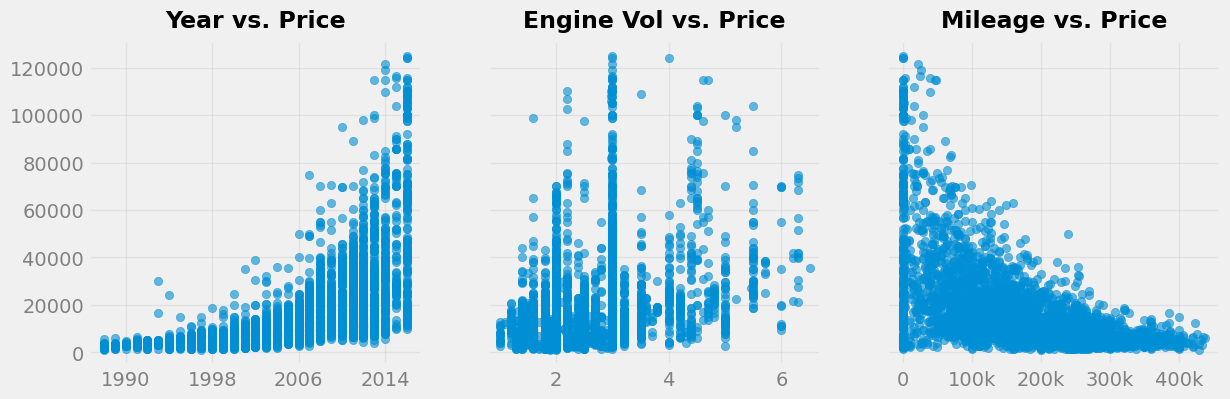

In [11]:
# Create subplots to visualize the relationship between the numerical variables and price
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(13, 4))

# Create scatter plot of 'Year' vs 'Price'
ax1.scatter(cars['Year'], cars['Price'], alpha=0.6)
ax1.set_title('Year vs. Price', weight='bold', size=17, pad=10)
ax1.set_xticks(np.arange(1990, 2022, 8))

# Create scatter plot of 'EngineV' vs 'Price'
ax2.scatter(cars['EngineV'], cars['Price'], alpha=0.6)
ax2.set_title('Engine Vol vs. Price', weight='bold', size=17, pad=10)
ax2.set_xlim([0.8, 6.7])

# Create scatter plot of 'Mileage' vs 'Price'
ax3.scatter(cars['Mileage'], cars['Price'], alpha=0.6)
ax3.set_title('Mileage vs. Price', weight='bold', size=17, pad=10)
ax3.set_xticks(np.arange(0, 500000, 100000), ['0', '100k', '200k', '300k', '400k'])

# Customize tick labels and gridlines
for ax in (ax1, ax2, ax3):
    ax.tick_params(axis='both', colors='grey')
    ax.grid(alpha=0.4)

# Display the plots
plt.show()

While there are patterns, they are definitely not linear, indicating that we should transform at least one variable. Based on the distribution of price, it appears to be exponentially distributed, which explains its exponential relationship, particularly with mileage and year. A common way to address this issue is by applying a log transformation to the `Price` column.

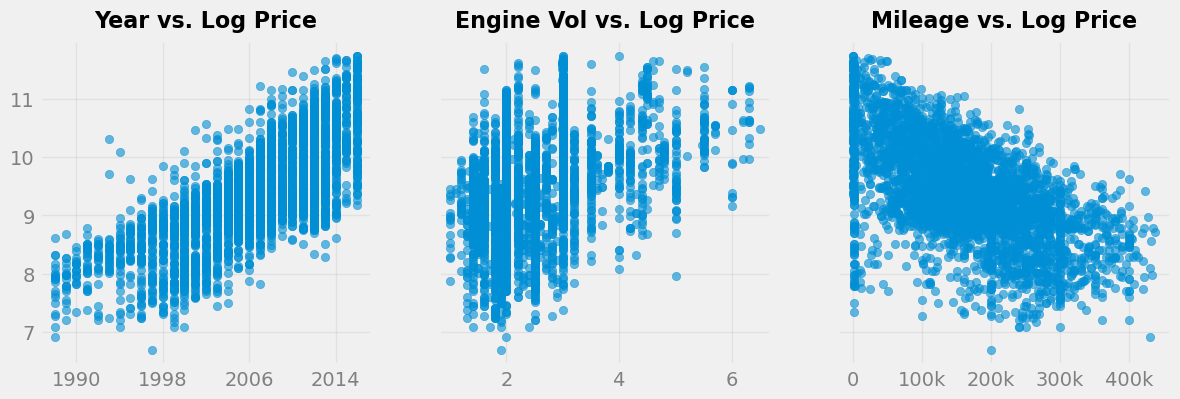

In [12]:
# Apply log transformation to the 'Price' column to address non-linearity
cars['log_price'] = np.log(cars['Price'])

# Create subplots to visualize the relationship between 
# the numerical variables and log-transformed price
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(13, 4))

# Create scatter plot of 'Year' vs 'log_price'
ax1.scatter(cars['Year'], cars['log_price'], alpha=0.6)
ax1.set_title('Year vs. Log Price', weight='bold', size=16, pad=10)
ax1.set_xticks(np.arange(1990, 2022, 8))

# Create scatter plot of 'EngineV' vs 'log_price'
ax2.scatter(cars['EngineV'], cars['log_price'], alpha=0.6)
ax2.set_title('Engine Vol vs. Log Price', weight='bold', size=16, pad=10)
ax2.set_xlim([0.8, 6.7])

# Create scatter plot of 'Mileage' vs 'log_price'
ax3.scatter(cars['Mileage'], cars['log_price'], alpha=0.6)
ax3.set_title('Mileage vs. Log Price', weight='bold', size=16, pad=10)
ax3.set_xticks(np.arange(0, 500000, 100000), ['0', '100k', '200k', '300k', '400k'])

# Customize tick labels and gridlines
for ax in (ax1, ax2, ax3):
    ax.tick_params(axis='both', colors='grey')
    ax.grid(alpha=0.4)

# Display the plots
plt.show()

After applying the log transformation to the `Price` column, we can clearly see the difference before and after the transformation. The relationship between log price and the three numerical variables is now closer to linear. As a result, we will drop the original `Price` column and keep `log_price`.

In [13]:
# Drop the original 'Price' column after applying log transformation
cars.drop(['Price'], axis=1, inplace=True)

It's worth noting that checking the linearity assumption only between numerical features and the target might miss non-linear relationships involving categorical variables or interactions between features. This incomplete analysis can overlook important effects on the target variable. However, we'll proceed without examining the categorical variables and see how our OLS model performs.

### 3.2. No Multicollinearity

No multicollinearity means that independent variables should not be highly correlated with each other. To assess multicollinearity, we'll use the Variance Inflation Factor (VIF), which measures how much the variance of a regression coefficient increases due to collinearity.

In [14]:
# Reorder columns in the DataFrame
cars = cars[['log_price', 'Mileage', 'EngineV', 'Year', 'Brand_BMW', 'Brand_Mercedes-Benz',
             'Brand_Volkswagen', 'Brand_Mitsubishi', 'Brand_Toyota', 'Brand_Renault', 
             'Body_hatch', 'Body_sedan', 'Body_vagon', 'Body_van', 'Body_other', 
             'Engine Type_Gas', 'Engine Type_Petrol', 'Engine Type_Other', 'Registration_yes']]

# Convert Boolean columns to integers (1 and 0)
boolean_cols = cars.iloc[:, 4:].select_dtypes(include='bool').columns
cars[boolean_cols] = cars[boolean_cols].astype(int)

# Initialize a DataFrame and calculate VIF for each column
vif_table = pd.DataFrame()
vif_table["VIF"] = [variance_inflation_factor(cars.values, i) for i in range(cars.shape[1])]
vif_table["Variable"] = cars.columns

# Sort VIF values in descending order and display the DataFrame
vif_table = vif_table.sort_values(by="VIF", ascending=False)
vif_table

,VIF,Variable
3,531.054202,Year
0,501.727876,log_price
18,18.246649,Registration_yes
2,13.993294,EngineV
1,8.944484,Mileage
11,4.109484,Body_sedan
6,3.516154,Brand_Volkswagen
5,3.043608,Brand_Mercedes-Benz
13,2.888367,Body_van
16,2.689009,Engine Type_Petrol


Clearly, `log_price` has an exceptionally high VIF of `531.05`, indicating strong linear correlation with other variables. This is expected since we aim to use `log_price` as the dependent variable in our OLS linear regression model.

To properly assess multicollinearity among predictors, we need to exclude `log_price` from the VIF analysis, as multicollinearity concerns only the independent variables.

In [15]:
# Select all columns except 'log_price' for VIF calculation
predictors = cars.iloc[:, 1:]

# Initialize a DataFrame and calculate VIF for each predictor variable
vif_table = pd.DataFrame()
vif_table["VIF"] = [variance_inflation_factor(predictors.values, i) 
                    for i in range(predictors.shape[1])]
vif_table["Variable"] = predictors.columns

# Sort VIF values in descending order and display the DataFrame
vif_table = vif_table.sort_values(by="VIF", ascending=False)
vif_table

,VIF,Variable
2,44.339208,Year
17,12.453566,Registration_yes
1,12.118698,EngineV
0,4.916428,Mileage
10,3.748744,Body_sedan
5,3.453612,Brand_Volkswagen
4,3.043522,Brand_Mercedes-Benz
12,2.705946,Body_van
3,2.597333,Brand_BMW
15,2.515468,Engine Type_Petrol


Since `Year` has the highest VIF at `44.34`, we will remove it from our dataset. It’s important to note that removing a feature with a high VIF will generally reduce the VIF values of the remaining variables.

The main issue with the registration variable is that most values are `1` (or `yes`). Since good predictors are effective at determining `log_price`, and if `Registration` is mostly `yes`, predicting `log_price` will likely also predict `Registration` as `yes`. Therefore, when a single category is so predominant, it's generally better to drop the variable.

In [16]:
# Drop 'Year' and 'Registration_yes' columns from predictor variables
predictors.drop(['Year', 'Registration_yes'], axis=1, inplace=True)

# Initialize a DataFrame and calculate VIF for each predictor variable
vif_table = pd.DataFrame()
vif_table["VIF"] = [variance_inflation_factor(predictors.values, i) 
                    for i in range(predictors.shape[1])]
vif_table["Variable"] = predictors.columns

# Sort VIF values in descending order and display the DataFrame
vif_table = vif_table.sort_values(by="VIF", ascending=False)
vif_table

,VIF,Variable
1,6.224364,EngineV
0,4.524581,Mileage
9,3.028737,Body_sedan
3,2.649770,Brand_Mercedes-Benz
14,2.430224,Engine Type_Petrol
4,2.428292,Brand_Volkswagen
11,2.328969,Body_van
2,2.168029,Brand_BMW
6,1.935374,Brand_Toyota
7,1.800175,Brand_Renault


Overall, the VIF values are now significantly lower compared to before, indicating that the removal of `Year` and `Registration_yes` effectively reduced multicollinearity.

Except for `EngineV`, which has a VIF value of `6.22`, all remaining VIF values are below `5`, suggesting that multicollinearity is now within acceptable limits. Therefore, no further features need to be removed based on these VIF values, and we'll keep `EngineV` as well.

### 3.3. Normality and Homoscedasticity

First, it’s crucial to test the individual impact of each feature on the target variable by calculating F-scores and p-values, and to determine whether these relationships are statistically significant.

In univariate linear regression, the normality of error terms is crucial for hypothesis testing and calculating p-values. While the F-test assumes normally distributed residuals for validity in small samples, slight deviations from normality typically don't significantly impact results in large datasets.

With a sample of `30` or more observations, the central limit theorem helps ensure that the distribution of error terms approximates normality, even if the underlying error terms are not normally distributed. This makes the assumption of normality less critical.

In [17]:
# Select feature columns and target variable
X = predictors
y = cars['log_price']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit StandardScaler on the training data, then transform train and test data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Perform univariate linear regression test for each feature
f_scores, p_values = f_regression(X_train, y_train)

# Create a DataFrame with feature names, F-scores, and p-values
f_regression_df = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': f_scores.round(2),
    'P-Value': p_values.round(4)
})

# Display the DataFrame
f_regression_df

,Feature,F-Score,P-Value
0,Mileage,1799.30,0.0000
1,EngineV,623.04,0.0000
2,Brand_BMW,24.69,0.0000
3,Brand_Mercedes-Benz,51.09,0.0000
4,Brand_Volkswagen,38.21,0.0000
5,Brand_Mitsubishi,18.25,0.0000
6,Brand_Toyota,77.26,0.0000
7,Brand_Renault,130.69,0.0000
8,Body_hatch,57.38,0.0000
9,Body_sedan,56.59,0.0000


The F-scores indicate that all features, except `Body_other` and `Engine Type_Other`, are highly significant with p-values at or near `0.0000`. Nevertheless, `Body_other` and `Engine Type_Other` are still significant, with p-values of `0.0436` and `0.0329`, respectively. Since no variable exceeds the typical significance threshold of `0.05`, this suggests they are statistically significant and do not necessarily need to be removed.

Next, let's fit the model to the training data, and predict the target values using the test set.

In [18]:
# Initialize LinearRegression and fit the OLS model to the training data
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)

# Predict the target values using the test set
y_pred = ols_model.predict(X_test)

Normality assumes that the residuals in a regression model are normally distributed, forming a bell-shaped curve centered around zero. Homoscedasticity means that the residuals have constant variance across all levels of the independent variables, with no increasing or decreasing spread. 

To check the normality of residuals, we can use a probability density function (PDF) plot with a kernel density estimate (KDE). To assess homoscedasticity, we can create a scatter plot of the residuals against the predicted log prices.

Mean of residuals: -0.0399


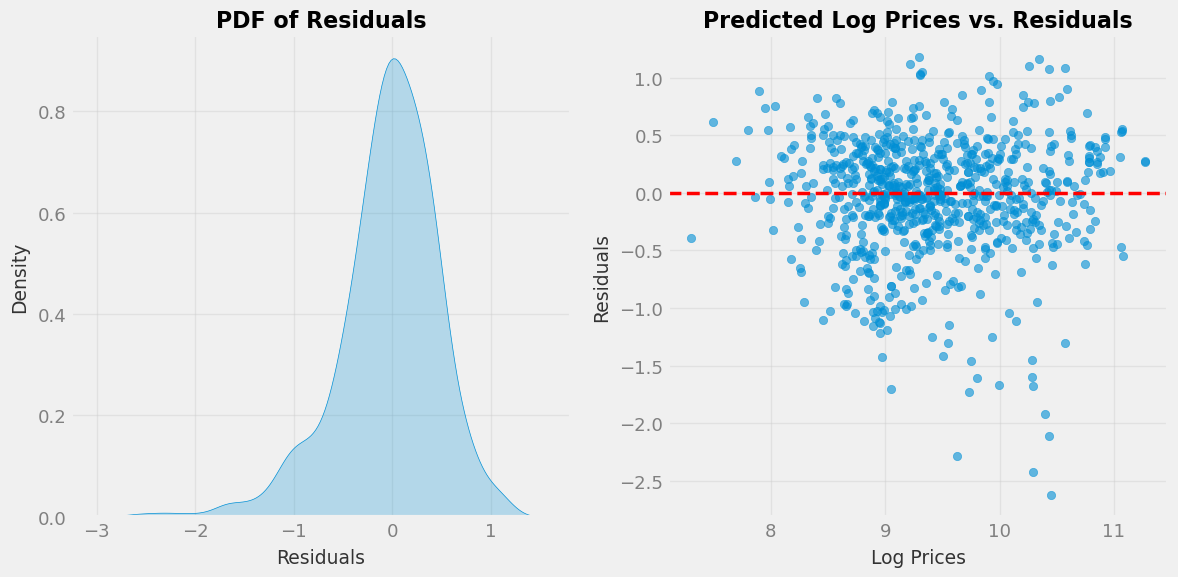

In [19]:
# Calculate residuals and print their mean
residuals = y_test - y_pred
print(f'Mean of residuals: {residuals.mean().round(4)}')

# Make a figure with two subplots
plt.figure(figsize=(12, 6))

# Create PDF of residuals
plt.subplot(1, 2, 1)
sns.kdeplot(residuals, fill=True)
plt.title('PDF of Residuals', fontsize=16, fontweight='bold')
plt.xlabel('Residuals', color='#333333', labelpad=6, size=13.5)
plt.ylabel('Density', color='#333333', labelpad=6, size=13.5)

# Create scatter plot of predicted log prices vs residuals
plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=2.5)
plt.title('Predicted Log Prices vs. Residuals', size=16, fontweight='bold')
plt.xlabel('Log Prices', color='#333333', labelpad=6, size=13.5)
plt.ylabel('Residuals', color='#333333', labelpad=6, size=13.5)

# Customize tick parameters and gridlines for both subplots
for i in range(1, 3):
    plt.subplot(1, 2, i)
    plt.xticks(size=13, color='grey')
    plt.yticks(size=13, color='grey')
    plt.grid(alpha=0.4)

# Adjust padding and display the plots
plt.tight_layout()
plt.show()

While the residuals' PDF approximates a normal distribution and the mean of the residuals is close to `0`, several negative residuals deviate significantly from the mean. Since residuals are defined as $y_{\text{test}} - y_{\text{pred}}$, negative values indicate that predictions are higher than the actual targets.

The scatter plot of predicted log prices versus residuals further supports this, showing that residuals don't exhibit constant variance. They range from approximately `-2.6` to `1.2` and are not consistently centered around `0`, indicating potential issues with homoscedasticity.

Therefore, adding new relevant variables or using a new set of features might improve the model and better satisfy the assumptions of normality and homoscedasticity.

### 3.4. No Autocorrelation

No autocorrelation means the residuals from a regression model are not correlated with each other, indicating that the model’s errors are random and don't follow a discernible pattern. 

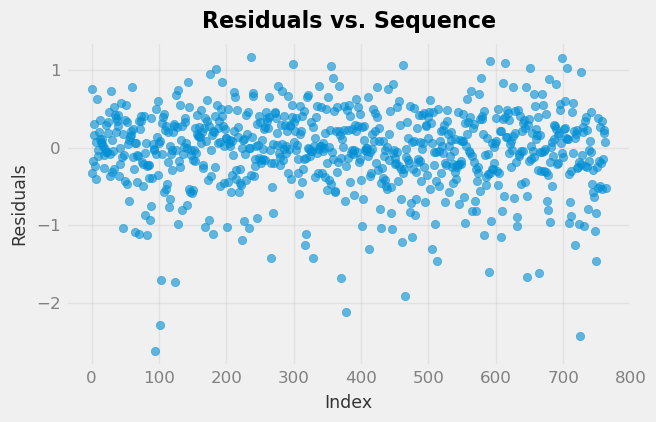

In [20]:
# Set figure size and plot residuals against their index (sequence)
plt.figure(figsize=(6.5, 4))
plt.scatter(np.arange(len(residuals)), residuals, alpha=0.6)

# Add title and set labels to the x- and y-axis
plt.title('Residuals vs. Sequence', fontweight='bold', size=16, pad=10)
plt.ylabel('Residuals', color='#333333', labelpad=6, size=12.5)
plt.xlabel('Index', color='#333333', labelpad=6, size=12.5)

# Customize ticks and gridlines
plt.xticks(size=12, color='grey')
plt.yticks(size=12, color='grey')
plt.grid(alpha=0.4)

# Display the plot
plt.show()

We observe no discernible pattern that indicates autocorrelation, as the residual values are scattered randomly. The Durbin-Watson statistic also helps detect the presence of autocorrelation in the residuals, confirming that we have not violated this assumption.

In [21]:
# Calculate Durbin-Watson statistic
dw_statistic = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw_statistic:.2f}')

Durbin-Watson statistic: 2.05


A Durbin-Watson statistic of `2.05` suggests no significant autocorrelation in the residuals, as it's close to the ideal value of `2`. This indicates that the residuals are very likely independent of each other.

## 4. Evaluating the OLS Linear Model

Now that we've fully prepared our dataset and checked `4` linear regression assumptions, we're ready to evaluate our OLS linear regression model's performance using the R-squared metric and calculate the intercept and the coefficients.

In [22]:
# Calculate R-squared scores for training and test sets
train_score = ols_model.score(X_train, y_train)
test_score = ols_model.score(X_test, y_test)

# Print R-squared scores, intercept, and coefficients
print(f'Training R-squared: {train_score:.4f}, Test R-squared: {test_score:.4f}')
print(f'Intercept: {ols_model.intercept_.round(2)}')
print(f'Coefficients: {ols_model.coef_.round(2)}')

Training R-squared: 0.6313, Test R-squared: 0.6428
Intercept: 9.41
Coefficients: [-0.52  0.23  0.04  0.06 -0.03 -0.09 -0.   -0.12 -0.16 -0.22 -0.16 -0.13
 -0.1  -0.08 -0.09 -0.02]


The model performs with the training R-squared at `0.6313` and the test R-squared higher at `0.6428`, indicating a moderate fit and generalization ability. The coefficients indicate the impact of each standardized feature on the log-transformed price. Overall, most features have a negative relationship with `log_price`.

While holding other variables constant, a coefficient of `-0.52` means that for a one standard deviation increase in mileage, the price decreases by approximately `52%`. Conversely, a coefficient of `0.23` indicates that for a one standard deviation increase in engine volume, the price increases by about `23%`.

Next, let's calculate the adjusted R-squared on the test data. This metric accounts for the number of predictors in the model, providing a more accurate measure of model fit when comparing models with different numbers of features:

$$R^2_{adj.} = 1 - (1-R^2)×\frac{n-1}{n-p-1}$$

In [23]:
# Calculate R-squared from the true and predicted values
r2 = r2_score(y_test, y_pred)

# Calculate the number of observations and features in the test set
n = X_test.shape[0]
p = X_test.shape[1]

# Calculate the test adjusted R-squared and print the result
adj_r2 = 1 - (1-r2) * (n-1) / (n-p-1)
print(f'Test adjusted R-squared: {adj_r2:.4f}')

Test adjusted R-squared: 0.6351


The test adjusted R-squared of `0.6351`, slightly lower than the test R-squared of `0.6428`, accounts for the number of predictors and further confirms the model's overall performance and goodness of fit.

A simple way to compare the actual target values of the training set with their predictions is by plotting them on a scatter plot. The closer the points are to the 45-degree line, the better the predictions.

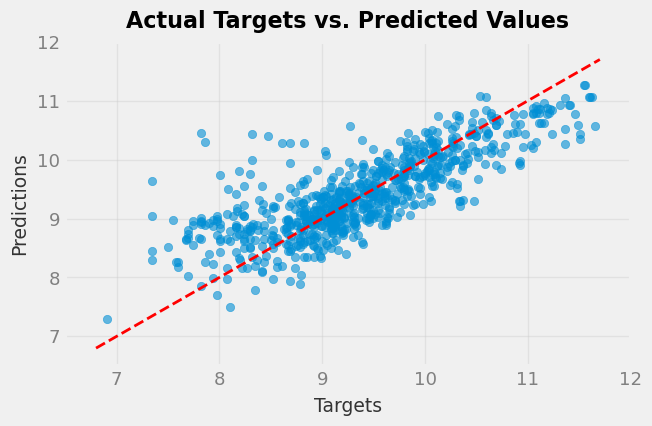

In [24]:
# Set figure size and create a scatter plot of actual targets vs predicted values
plt.figure(figsize=(6.5, 4))
plt.scatter(y_test, y_pred, alpha=0.6)

# Add a 45-degree line
plt.plot([6.8, 11.7], [6.8, 11.7], color='red', linestyle='--', linewidth=2)

# Add a title and set labels to the x and y axes
plt.title('Actual Targets vs. Predicted Values', fontweight='bold', size=16, pad=10)
plt.xlabel('Targets', color='#333333', labelpad=6, size=13.5)
plt.ylabel('Predictions', color='#333333', labelpad=6, size=13.5)

# Customize tick parameters and grid lines, and set x- and y-limits
plt.xticks(size=13, color='grey')
plt.yticks(size=13, color='grey')
plt.grid(alpha=0.4)
plt.xlim(6.5, 12)
plt.ylim(6.5, 12)

# Display the plot
plt.show()

Although the points generally follow a linear pattern, they are scattered around the 45-degree line. For target values less than `9`, the points are often farther from and above the line, indicating that the model overpredicted in these cases, leading to larger errors. Additionally, the highest target values tend to be below the 45-degree line, which suggests that the model underpredicted those values.

Next, let's use K-fold cross-validation to ensure our model's performance is reliable and not just tailored to our specific train-test split. This will provide a more robust estimate of the model's generalization ability.

In [25]:
# Perform 5-fold cross-validation and get the R-squared values
cv_scores = cross_val_score(ols_model, X_train, y_train, cv=5, scoring='r2')

# Print the individual R-squared scores for each fold and the mean R-squared score
print(f'Cross-validated R-squared scores for each fold: {cv_scores.round(2)}')
print(f'Mean Cross-validated R-squared: {cv_scores.mean():.4f}')

Cross-validated R-squared scores for each fold: [0.64 0.58 0.61 0.62 0.68]
Mean Cross-validated R-squared: 0.6247


The model demonstrates consistent performance, with the training R-squared at `0.6313` and test R-squared at `0.6428`. The cross-validated R-squared scores across folds are relatively stable, with an average of `0.6247`, indicating that the model generalizes well and has no major issues with overfitting.

## 5. Building Polynomial and Spline Models

When using polynomial features, we transform the original features into higher-degree combinations to capture more complex, non-linear relationships. This can model non-linear trends but also increases the risk of overfitting. While the fundamental assumptions of linear regression, such as linearity, homoscedasticity, and normality, still apply, the model incorporates polynomial terms to address non-linear relationships.

Splines are piecewise polynomial functions that model non-linear relationships by dividing the data into segments, or knots, and fitting polynomials to each. They capture complex patterns and allow the model to adapt to non-linear trends. However, while splines can improve performance, they can also lead to overfitting if the complexity is not properly controlled.

To start, we'll use Recursive Feature Elimination (RFE) to select a predefined number of predictors and create polynomial features. After building the model, we will apply K-fold cross-validation to ensure its performance is reliable and not just specific to our train-test split.

In [26]:
# Select feature columns and target variable
X = cars.drop(['log_price'], axis=1)
y = cars['log_price']

# Fit scaler to X and transform all feature data
X_scaled = scaler.fit_transform(X)

# Initialize RFE with Linear Regression, select the number of features, and fit RFE on the transformed data
rfe = RFE(estimator=LinearRegression(), n_features_to_select=13)
rfe.fit(X_scaled, y)

# Print the names of the selected features based on RFE support
selected_features = X.columns[rfe.support_]
print(f'Selected Features: {list(selected_features)}', end='\n\n')


# Split data into training and test sets with selected features
X_train, X_test, y_train, y_test = train_test_split(cars[selected_features], y, test_size=0.3, random_state=42)

# Create polynomial features (degree=2) for the training and test sets
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_X_train = poly.fit_transform(X_train)
poly_X_test = poly.transform(X_test)

# Scale polynomial features for training and test sets
poly_X_train_scaled = scaler.fit_transform(X_train)
poly_X_test_scaled = scaler.transform(X_test)

# Initialize and fit LinearRegression on polynomial training features
poly_model = LinearRegression()
poly_model.fit(poly_X_train_scaled, y_train)


# Calculate and print R-squared for training and test sets
train_score = poly_model.score(poly_X_train_scaled, y_train)
test_score = poly_model.score(poly_X_test_scaled, y_test)
print(f'Training R-squared: {train_score:.4f}, Test R-squared: {test_score:.4f}')

# Calculate the test adjusted R-squared and print the result
r2 = test_score
n = poly_X_test_scaled.shape[0]
p = poly_X_test_scaled.shape[1]
adj_r2 = 1 - (1-r2) * (n-1) / (n-p-1)
print(f'Test adjusted R-squared: {adj_r2:.4f}', end='\n\n')

# Perform 5-fold cross-validation and print R-squared scores
cv_scores = cross_val_score(poly_model, poly_X_train_scaled, y_train, cv=5, scoring='r2')
print(f'Cross-validated R-squared scores for each fold: {cv_scores.round(2)}')
print(f'Mean Cross-validated R-squared: {cv_scores.mean():.4f}')

Selected Features: ['Mileage', 'EngineV', 'Year', 'Brand_Volkswagen', 'Brand_Mitsubishi', 'Brand_Toyota', 'Brand_Renault', 'Body_hatch', 'Body_sedan', 'Body_vagon', 'Body_van', 'Body_other', 'Registration_yes']

Training R-squared: 0.8841, Test R-squared: 0.8755
Test adjusted R-squared: 0.8741

Cross-validated R-squared scores for each fold: [0.89 0.88 0.9  0.85 0.88]
Mean Cross-validated R-squared: 0.8822


The polynomial features model significantly outperforms the OLS model, selecting `13` features through RFE. Specifically, the polynomial model achieves a training R-squared of `0.8841` and a test R-squared of `0.8755`, compared to the OLS model's `0.6313` and `0.6428`, respectively.

Additionally, the polynomial model's cross-validated R-squared mean score is `0.8822`, markedly higher than the OLS model's mean of `0.6247`. The test adjusted R-squared of `0.8741` suggests a strong fit while accounting for model complexity.

The high training and test R-squared scores indicate minimal overfitting, and the consistent cross-validated R-squared scores across folds demonstrate reliable and stable performance across different subsets of the data.

Next, we'll optimize a spline model and test various parameters to find the best-performing combination. In this case, we will select all the features for our dataset.

In [27]:
# Select feature columns and target variable
X = cars.drop(['log_price'], axis=1)
y = cars['log_price']

# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit scaler on the training data, then transform training and test data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Define the parameter grid for GridSearchCV
param_grid = {
    'spline__degree': np.arange(2, 5),
    'spline__n_knots': np.arange(10, 15),
    'model__fit_intercept': [True, False],
    'spline__include_bias': [True, False]
}

# Create a pipeline that includes SplineTransformer and LinearRegression
pipeline = Pipeline([
    ('spline', SplineTransformer()),
    ('model', LinearRegression())
])


# Initialize GridSearchCV with pipeline and parameter grid, and fit it to the training data
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Extract the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_


# Evaluate the best model's performance on train and test sets, and display the optimal parameters
train_score = best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)
print(f'Best Parameters: {best_params}')
print(f'Training R-squared: {train_score:.4f}, Test R-squared: {test_score:.4f}')

# Calculate the test adjusted R-squared and print the result
r2 = test_score
n = X_test.shape[0]
p = X_test.shape[1]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Test adjusted R-squared: {adj_r2:.4f}')

Best Parameters: {'model__fit_intercept': False, 'spline__degree': 3, 'spline__include_bias': False, 'spline__n_knots': 14}
Training R-squared: 0.9052, Test R-squared: 0.8927
Test adjusted R-squared: 0.8910


The optimized spline model achieves a training R-squared of `0.9052` and a test R-squared of `0.8927`, indicating minimal overfitting and strong generalization. The test adjusted R-squared of `0.8910` confirms the model explains most variance while accounting for complexity.

[GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) enhances the model by cross-validating different hyperparameter combinations, selecting the best configuration based on R-squared, ensuring robust performance across data splits.

## 6. Conclusion

In this project, we built predictive models for car prices using both linear and non-linear approaches. The dataset contains secondhand car prices from various brands, different years, and specifications, reflecting a diverse selection.

To clean the dataset, we removed duplicate rows, handled missing data, and eliminated extreme outliers. Additionally, we dropped features that were deemed irrelevant or less useful for our predictions. To conclude the data cleaning process, we reset the index of our DataFrame and created dummy variables for the categorical columns.

Although OLS (Ordinary Least Squares) is one of the most common methods for estimating linear regression equations, its simplicity means it cannot always be used. As a result, we checked four key linear regression assumptions before relying on this estimation method:

- We applied a log transformation to the `Price` column so that the relationship between log price and the numerical variables becomes closer to linear, and then proceeded without examining the target with categorical variables.
- The removal of the `Year` and `Registration_yes` columns effectively reduced multicollinearity. Except for `EngineV`, which has a VIF value of `6.22`, all remaining VIF values are below `5`, indicating that multicollinearity was reduced to acceptable levels.
- While the residuals' PDF approximates a normal distribution and the mean of the residuals is close to `0`, several negative residuals deviate significantly from the mean. Additionally, the scatter plot of predicted log prices versus residuals shows that the residuals don't exhibit constant variance and aren't consistently centered around zero. We decided that adding new relevant variables or using a different set of features might better satisfy the assumptions of normality and homoscedasticity.
- After plotting the residuals against their index, we observed no discernible pattern indicating autocorrelation, as the residual values appear randomly scattered. The Durbin-Watson statistic, calculated at `2.05`, suggests no significant autocorrelation in the residuals, as it is close to the ideal value of `2`.

Here's a table that gathers the key metrics for each model:

| **Model**                        | **Training R-squared** | **Test R-squared** | **Test Adjusted R-squared**  | **Mean Cross-validated R-squared**              |
|----------------------------------|------------------------|--------------------|------------------------------|-------------------------------------------------|
| **OLS (Ordinary Least Squares)** | 0.6313                 | 0.6428             | 0.6351                       | 0.6247                                          |
| **Polynomial Features**          | 0.8841                 | 0.8755             | 0.8741                       | 0.8822                                          |
| **Spline**                       | 0.9052                 | 0.8927             | 0.8910                       | N/A                                             |

- For the OLS model, the training and test R-squared values were significantly lower than those of the more complex models. Since the test adjusted R-squared accounts for the number of predictors, it's slightly lower than the test R-squared.
- To create polynomial features, we used Recursive Feature Elimination (RFE) to select a predefined number of features (`13` in our case). The R-squared values are much higher compared to OLS, indicating a better fit. Although this comes with a risk of overfitting, the training score is only slightly higher than the test score. Since both the test adjusted and mean cross-validated R-squared values are close to the test R-squared, this confirms that the model generalizes well.
- We optimized a spline model and tested various parameters to find the best-performing combination. In this case, we selected all the features for our dataset. The performance is similar to the polynomial model, with slightly higher R-squared values. Since we employed [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to tune hyperparameters (degree, number of knots, etc.), we evaluated the best model's performance on the training and test sets and then calculated the test adjusted R-squared.

In short, while both the polynomial and spline models significantly outperform OLS in terms of R-squared values, the spline model demonstrates the best generalization. The polynomial features, on the other hand, offer competitive performance.